In [109]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 1
%aimport deconvolution
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pygenesig.file_formats import * 
from pygenesig.tools import *
from deconvolution import * 
from scipy.stats import mannwhitneyu
from pylab import * 

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We now need to evaluate the deconvolution on data that 
was neither used for signature generation nor for the computation of the relative rank. 

SQL query to find other mouse studies with multiple tissues: 

```sql
with x as (
select bgg.gse
      , count(distinct bss.tissue) as cnt
from BIOQC_SELECTED_SAMPLES bss
join bioqc_gse_gsm bgg
  on bgg.gsm = bss.gsm
where bss.ORGANISM = 'Mus musculus'
and GPL = 'GPL1261'
group by gse)
select /*+ parallel(16) */  * from x
join bioqc_gse bge
  on x.gse = bge.gse
order by cnt desc
```

One such study is `GSE24207`

In [6]:
%%bash
this_dir=$(pwd)/data
cd ../BioQC_GEO_analysis/
./scripts/geo_to_eset.R GSE24207 $this_dir

[1] "GEO ID:  GSE24207"
[1] "OUTFILE:  /pstore/home/sturmg/projects/BioQC-significance/data/%s.Rdata"
[1] "Storing expression set to /pstore/home/sturmg/projects/BioQC-significance/data/GSE24207.Rdata"


https://ftp.ncbi.nlm.nih.gov/geo/series/GSE24nnn/GSE24207/matrix/
OK
Found 1 file(s)
GSE24207_series_matrix.txt.gz
trying URL 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE24nnn/GSE24207/matrix/GSE24207_series_matrix.txt.gz'
Content type 'application/x-gzip' length 4427708 bytes (4.2 MB)
downloaded 4.2 MB

File stored at: 
/local/2844607/RtmpHgTDwk/GPL1261.annot.gz
There were 31 warnings (use warnings() to see them)


In [8]:
!./eset_to_python.R

[1] "Estabilshin RJDBC connection to bin"
Loading required package: BiocGenerics
Loading required package: methods
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introducto

In [45]:
signatures = load_gmt("../pygenesig-example/results/gtex_v6_solid_gini_0.8_1/signatures.gmt")

In [94]:
rel_ranks = pd.read_csv("./results/rel_ranks_gtex_mouse_affy.tsv", header=None, sep="\t", index_col=None)
rel_ranks = dict(zip(rel_ranks[0], rel_ranks[1]))

In [39]:
exprs_raw = read_gct("data/GSE24207_exprs.gct")
fdata = pd.read_csv("data/GSE24207_fdata.tsv", sep="\t")
pdata = pd.read_csv("data/GSE24207_pdata.tsv", sep="\t")

In [40]:
target = np.array([x.replace("Mouse ", "") for x in pdata.source_name_ch1])

In [64]:
exprs_collapsed_df = collapse_matrix(exprs_raw, fdata.BioqcGeneSymbol)
exprs_collapsed_df = exprs_collapsed[exprs_collapsed.index != '-']
rosetta = make_rosetta_dict(exprs_collapsed_df.index.values, inverse=True)
exprs = exprs_collapsed_df.values

In [42]:
target.shape, exprs.shape

((73,), (16199, 73))

In [116]:
np.array(sorted(target))

array(['adipose tissue', 'adipose tissue', 'adipose tissue',
       'adrenal gland', 'adrenal gland', 'adrenal gland', 'bone marrow',
       'bone marrow', 'bone marrow', 'bone marrow', 'brain', 'brain',
       'brain', 'diaphragm', 'diaphragm', 'diaphragm', 'eye', 'eye', 'eye',
       'heart', 'heart', 'heart', 'insulinoma', 'insulinoma', 'insulinoma',
       'kidney', 'kidney', 'kidney', 'liver', 'liver', 'liver', 'lung',
       'lung', 'lung', 'muscle', 'muscle', 'muscle', 'muscle', 'ovary',
       'ovary', 'ovary', 'pancreatic acini', 'pancreatic acini',
       'pancreatic acini', 'pancreatic isltes', 'pancreatic isltes',
       'pancreatic isltes', 'pituitary gland', 'pituitary gland',
       'pituitary gland', 'pituitary gland', 'pituitary gland', 'placenta',
       'placenta', 'placenta', 'salivary gland', 'salivary gland',
       'salivary gland', 'seminal vesicle', 'seminal vesicle',
       'seminal vesicle', 'small intestine', 'small intestine',
       'small intestine', 'spl

In [95]:
rel_ranks

{'Adrenal_Gland': 0.6530818244905684,
 'Bladder': 0.37697937038672641,
 'Brain_Amygdala': 0.37950287048135772,
 'Brain_Cerebellum': 0.18181818181818185,
 'Brain_Hippocampus': 0.2356633650873762,
 'Brain_Hypothalamus': 0.15869661220112294,
 'Liver': 0.046211595482934832,
 'Lung': 0.53088133240804991,
 'Muscle_Skeletal': 0.053372027001451015,
 'Ovary': 0.63563813008642989,
 'Pancreas': 0.17781212541795471,
 'Pituitary': 0.50009463125354869,
 'Prostate': 0.39839757743990922,
 'Spleen': 0.38612705822976467,
 'Stomach': 0.15320799949529998,
 'Testis': 0.13033877988770426,
 'Uterus': 0.33225033120938741}

In [67]:
signatures_ind = translate_signatures(signatures, rosetta, ignore_missing=True)

In [133]:
map_names = {
    'tissue1': {
        'signature': 'Muscle_Skeletal', # name of the GTEx signature
        'rel_ranks': 'Muscle_Skeletal', # name of the rel rank
        'dataset': 'muscle' # name of the tissue in the dataset to analyse
    },
    'tissue2': {
        'signature': 'Liver',
        'rel_ranks': 'Liver',
        'dataset': 'liver'
    }
}

In [134]:
rel_rk = {
    tissue: rel_ranks[names['rel_ranks']] for tissue, names in map_names.items()
}

In [135]:
sample_ind = {
    'tissue1': np.flatnonzero(target == map_names['tissue1']['dataset'])[0],
    'tissue2': np.flatnonzero(target == map_names['tissue2']['dataset'])[0]
}
sample_ind

{'tissue1': 6, 'tissue2': 10}

In [136]:
samples = {
    tissue: exprs[:, i] for tissue, i in sample_ind.items()
}
samples

{'tissue1': array([  28.,   14.,    7., ...,  106.,   84.,  253.]),
 'tissue2': array([ 242. ,   38. ,    3. , ...,  115.5,   96. ,  188. ])}

In [137]:
gene_mask = {
    tissue: np.array([True if i in signatures_ind[names['signature']] else False for i in range(exprs.shape[0])])
    for tissue, names in map_names.items()
}
gene_mask

{'tissue1': array([False, False, False, ..., False, False, False], dtype=bool),
 'tissue2': array([ True, False, False, ..., False, False, False], dtype=bool)}

In [138]:
sig_size = {
    tissue: sum(t_ind) for tissue, t_ind in gene_mask.items()
}
sig_size

{'tissue1': 138, 'tissue2': 266}

In [139]:
overlap = jaccard_ind(*(signatures_ind[names['signature']] for names in map_names.values()))
overlap

0.01

In [140]:
mixed = [mix(samples['tissue1'], samples['tissue2'], f) for f in np.arange(0, 1.01, 0.01)]

In [141]:
wmw_res = {
    tissue:  [mannwhitneyu(s_mixed[~gene_mask[tissue]], s_mixed[gene_mask[tissue]]) for s_mixed in mixed] for 
    tissue in map_names
}
wmw_res

{'tissue1': [MannwhitneyuResult(statistic=527402.5, pvalue=1.2252189116717547e-26),
  MannwhitneyuResult(statistic=958240.5, pvalue=0.0030569299958669647),
  MannwhitneyuResult(statistic=1090505.5, pvalue=0.37310755766896231),
  MannwhitneyuResult(statistic=986385.5, pvalue=0.012970828269708036),
  MannwhitneyuResult(statistic=911867.0, pvalue=0.00016573268663896761),
  MannwhitneyuResult(statistic=854383.0, pvalue=1.7398310205698142e-06),
  MannwhitneyuResult(statistic=808234.0, pvalue=2.0799333298719374e-08),
  MannwhitneyuResult(statistic=769856.5, pvalue=3.0949459761281481e-10),
  MannwhitneyuResult(statistic=737186.5, pvalue=5.8947252920678767e-12),
  MannwhitneyuResult(statistic=708496.5, pvalue=1.3632328715670934e-13),
  MannwhitneyuResult(statistic=683506.0, pvalue=4.1107212723383167e-15),
  MannwhitneyuResult(statistic=661133.0, pvalue=1.5025004109750344e-16),
  MannwhitneyuResult(statistic=641460.5, pvalue=7.1445267416750642e-18),
  MannwhitneyuResult(statistic=623251.5, pval

In [142]:
wmw_exp = {}
for tissue in map_names:
    y = np.repeat(np.percentile(samples[tissue], (1- rel_rk[tissue]) * 100), sig_size[tissue])
    u, p = mannwhitneyu(samples[tissue], y)
    wmw_exp[tissue] = (wmw_r(samples[tissue], y, u), u, p) 
wmw_exp

{'tissue1': (0.89320328415334282, 119370.0, 1.6854437020612049e-73),
 'tissue2': (0.90752515587381932, 199234.0, 6.0578847467821015e-143)}

In [143]:
u_exp = {
    tissue: wmw_u_exp(rel_rk[tissue], sig_size[tissue], samples[tissue].size) for tissue in gene_mask
}
u_exp

{'tissue1': 109720.13822471768, 'tissue2': 163611.71497066432}

In [144]:
wmw_score_corr = {
    tissue: [-np.log10(p) / -np.log10(wmw_exp[tissue][2]) for u, p in res] for tissue, res in wmw_res.items()
}
wmw_score = {
    tissue: [-np.log10(p) for u, p in res] for tissue, res in wmw_res.items()
}

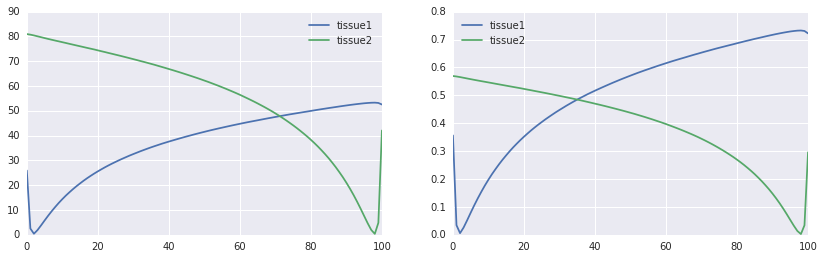

In [145]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(wmw_score).plot(ax=ax1)
pd.DataFrame(wmw_score_corr).plot(ax=ax2)

In [146]:
r = {
    tissue: [wmw_r(s_mixed[~gene_mask[tissue]], s_mixed[gene_mask[tissue]], u) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr = {
    tissue: [wmw_r(s_mixed[~gene_mask[tissue]], s_mixed[gene_mask[tissue]], u) / wmw_exp[tissue][0] for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}
r_corr_u = {
    tissue: [wmw_r_corr(s_mixed[~gene_mask[tissue]], s_mixed[gene_mask[tissue]], u, u_exp[tissue]) for u, p in res]
    for s_mixed, (tissue, res) in zip(mixed, wmw_res.items())
}

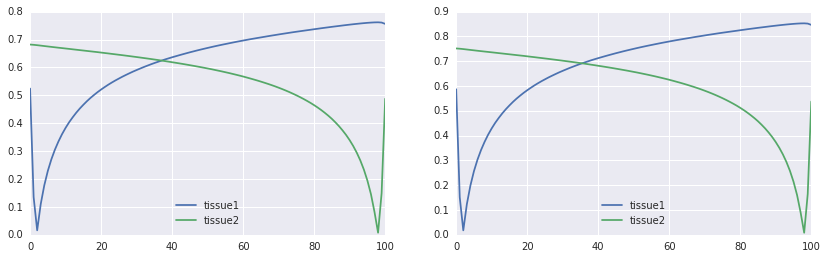

In [147]:
fix, (ax1, ax2) = subplots(1, 2, figsize=(14, 4))
pd.DataFrame(r).plot(ax=ax1)
pd.DataFrame(r_corr).plot(ax=ax2)

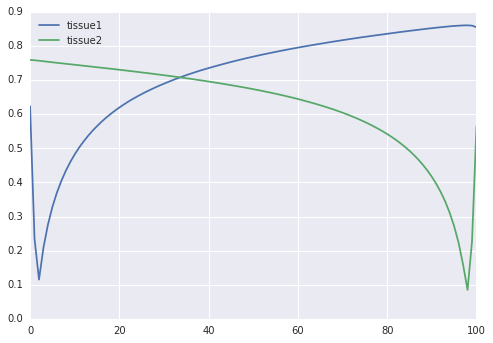

In [148]:
pd.DataFrame(r_corr_u).applymap(lambda x: x).plot()